In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

In this notebook I would like the answer the question-
“what sorts of people were more likely to survive?”
using some classification models that predicts which passengers survived the Titanic shipwreck.

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# **Importing the datasets**

## **Train data**

In [3]:
train_data = pd.read_csv('/kaggle/input/titanic/train.csv')
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


The train data contain information about 891 passengers (rows) and 12 columns.

In [4]:
train_data.shape

(891, 12)

## **Test data**

In [5]:
test_data = pd.read_csv('/kaggle/input/titanic/test.csv')
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


The test data contain information about 418 passengers (rows) and 11 columns.

In [6]:
test_data.shape

(418, 11)

# **Features Engineering & Data Analysis**

#### For Features Engineering let's combine the train set and the test set.

In [7]:
all_data = train_data.append(test_data)

In [8]:
all_data.shape

(1309, 12)

* #### **Adding Family_Size**

In [9]:
all_data['Family_Size'] = all_data['SibSp'] + all_data['Parch']

# Substituting the values in train_data and test_data:
train_data['Family_Size'] = all_data['Family_Size'][:891]
test_data['Family_Size'] = all_data['Family_Size'][891:]

* #### **Checking whether there are missing data**

In [10]:
all_data.columns[all_data.isna().any()].tolist()

['Survived', 'Age', 'Fare', 'Cabin', 'Embarked']

It's obvious why there are missing values in the Survived column...

For the rest columns with missing values, let's do some manipulations to fill up the empty cells.

* #### **Age**
To imputing the age more precisely, let's define a new temp column- 'Title' (the title of each passenger). 

In [11]:
all_data['Title'] = all_data['Name']
# Cleaning name and extracting Title
for name_string in all_data['Name']:
    all_data['Title'] = all_data['Name'].str.extract('([A-Za-z]+)\.', expand=True)

all_data.Title.unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'Countess',
       'Jonkheer', 'Dona'], dtype=object)

### The type of each column in the data frame:

In [12]:
train_data.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
Family_Size      int64
dtype: object

### Checking for missing data

In [13]:
# find the columns with Nans
train_data.columns[train_data.isna().any()].tolist()

['Age', 'Cabin', 'Embarked']

There are three columns with Nan values.

Let's replace the Nans in the Age column by the mean of the column.

In [14]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean') # replace the nan by the mean of the column's values
imputer.fit(train_data[['Age']])
train_data['Age'] = imputer.transform(train_data[['Age']])

The Cabin column and the Embarked column are object types, so we'll replace the Nans by empty string ''.

In [15]:
train_data['Cabin'].replace(np.nan, '', inplace = True)
train_data['Embarked'].replace(np.nan, '', inplace = True)

Now we will ensure there are no Nan values anymore-

In [16]:
train_data.isnull().values.any()
train_data.columns[train_data.isna().any()].tolist()

[]

**Good! there are no Nans.**

There are no duplicates:

In [17]:
train_data.duplicated().any()

False

For the sake of convenience, we will encode the Sex column into a new column- Sex_cat, where 0 = female and 1 = male.

Additionally, we will create a new column, AgeGroup, that will contain the age groups of the passengers according the following partition:
- Infant: 0-3
- Kid: 4-12
- Teen: 13-19
- Adult: 20-110

In [18]:
train_data["Sex"] = train_data["Sex"].astype('category')
train_data["Sex_cat"] = train_data["Sex"].cat.codes

bins= [0,4,13,20,110]
labels = ['Infant','Kid','Teen','Adult']
train_data['AgeGroup'] = pd.cut(train_data['Age'], bins=bins, labels=labels, right=False)
train_data.dtypes

PassengerId       int64
Survived          int64
Pclass            int64
Name             object
Sex            category
Age             float64
SibSp             int64
Parch             int64
Ticket           object
Fare            float64
Cabin            object
Embarked         object
Family_Size       int64
Sex_cat            int8
AgeGroup       category
dtype: object

In [19]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family_Size,Sex_cat,AgeGroup
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,,S,1,1,Adult
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,0,Adult
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,,S,0,0,Adult
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,0,Adult
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,,S,0,1,Adult


### Some statistics information:

In [20]:
train_data.iloc[:, 1:].describe(include='all')

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family_Size,Sex_cat,AgeGroup
count,891.000000,891.000000,891,891,891.000000,891.000000,891.000000,891,891.000000,891,891,891.000000,891.000000,891
unique,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,148,4,NaN,NaN,4
top,NaN,NaN,"Braund, Mr. Owen Harris",male,NaN,NaN,NaN,347082,NaN,,S,NaN,NaN,Adult
freq,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,687,644,NaN,NaN,727
mean,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN,0.904602,0.647587,NaN
std,0.486592,0.836071,NaN,NaN,13.002015,1.102743,0.806057,NaN,49.693429,NaN,NaN,1.613459,0.477990,NaN
min,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN,0.000000,0.000000,NaN
25%,0.000000,2.000000,NaN,NaN,22.000000,0.000000,0.000000,NaN,7.910400,NaN,NaN,0.000000,0.000000,NaN
50%,0.000000,3.000000,NaN,NaN,29.699118,0.000000,0.000000,NaN,14.454200,NaN,NaN,0.000000,1.000000,NaN
75%,1.000000,3.000000,NaN,NaN,35.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN,1.000000,1.000000,NaN


 #### According to the descriptive statistics table above-

**Survived:**
- Most of the passengers didn't survived (as we already know...), the mean = 0.3838 and the median = 0.

**Ticket Class (Pclass):**
- The mean = 2.3 and the median = 3, indicates that most tickets are for third class, and the minority are for first class.

**Sex**
- There are 577 male passengers and the rest are female.

**Age/AgeGroup**
- The average age is 29.699 and so the median, with a std of ~13. Most of the passengers are adults.

**Number of Siblings/Spouses (SibSp)**
- According to the mean and the median, most of the passengers came without their sibilig or spouses.

**Number of Parents/Children (Parch)**
- According to the mean and the median, most of the passengers came without their parents or children.

**Fare**
- It seems that most of the passengers paids for the trip below to 14.45 (A right skewed distribution, mean > median).

**Cabin**
- The mode of the cabin numer is unknown.

**Embarked**
- There three port of embarkation: C = Cherbourg, Q = Queenstown, S = Southampton. The common one is Southampton.

In [21]:
# corr = train_data.corr()
# mask = np.triu(np.ones_like(corr))

# sns.heatmap(corr, mask = mask, annot = True)

We can see a moderately negative correlation between the Sex variable ( = Sex_cat) and the Survived variable.

### Data Visualization
Helps us to understand better how the data are behaving

Text(0.5, 1.0, 'Passenger fare')

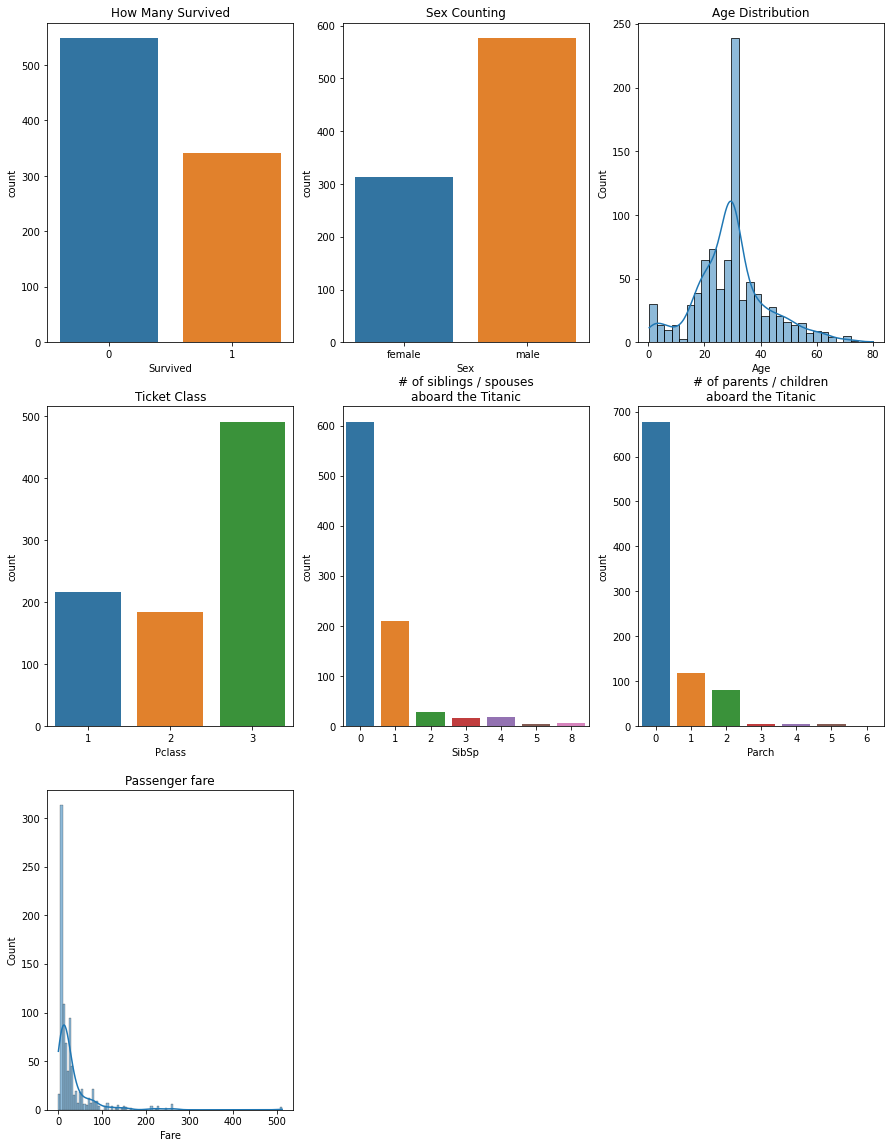

In [22]:
plt.figure(figsize = (15,20))

plt.subplot(3, 3, 1)
sns.countplot(x = 'Survived', data = train_data)
plt.title("How Many Survived")

plt.subplot(3, 3, 2)
sns.countplot(x = "Sex", data = train_data)
plt.title("Sex Counting")

plt.subplot(3, 3, 3)
sns.histplot(x = "Age", data = train_data, kde = True)
plt.title("Age Distribution")

plt.subplot(3, 3, 4)
sns.countplot(x = 'Pclass', data = train_data)
plt.title('Ticket Class')

plt.subplot(3, 3, 5)
sns.countplot(x = 'SibSp', data = train_data)
plt.title("# of siblings / spouses\naboard the Titanic")

plt.subplot(3, 3, 6)
sns.countplot(x = 'Parch', data = train_data)
plt.title('# of parents / children\naboard the Titanic')

plt.subplot(3, 3, 7)
sns.histplot(x = 'Fare', data = train_data, kde = True)
plt.title('Passenger fare')

#### We want to evaluate which features are affecting the chance to survive.
#### Accordingly, let's visually examine the connection.

**Survived ~ Sex**

% of men who survived: 0.18890814558058924
% of women who survived: 0.7420382165605095


<AxesSubplot:xlabel='Sex', ylabel='count'>

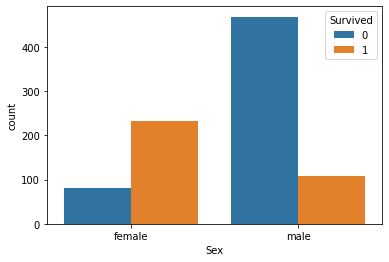

In [23]:
women = train_data.loc[train_data.Sex == "female"]['Survived']
rate_women = sum(women) / len(women)

men = train_data.loc[train_data.Sex == "male"]['Survived']
rate_men = sum(men) / len(men)

print("% of men who survived:", rate_men)
print("% of women who survived:", rate_women)

sns.countplot(x = 'Sex', data = train_data, hue = 'Survived')

**Survived ~ Ticket Class (Pclass)**

% of class 1 who survived: 0.6296296296296297
% of class 2 who survived: 0.47282608695652173
% of class 3 who survived: 0.24236252545824846


<AxesSubplot:xlabel='Pclass', ylabel='count'>

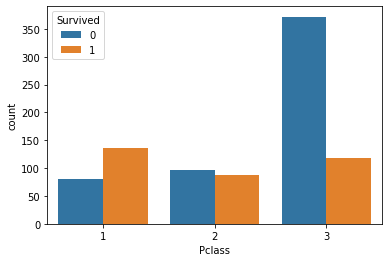

In [24]:
class1 = train_data.loc[train_data.Pclass == 1]['Survived']
rate_class1 = sum(class1) / len(class1)

class2 = train_data.loc[train_data.Pclass == 2]['Survived']
rate_class2 = sum(class2) / len(class2)

class3 = train_data.loc[train_data.Pclass == 3]['Survived']
rate_class3 = sum(class3) / len(class3)

print("% of class 1 who survived:", rate_class1)
print("% of class 2 who survived:", rate_class2)
print("% of class 3 who survived:", rate_class3)

sns.countplot(x = 'Pclass', data = train_data, hue = 'Survived')

**Survived ~ # of Parents/Children (Parch)**

% of passengers who have  0  of parents/children aboard the Titanic that survived: 0.34365781710914456
% of passengers who have  1  of parents/children aboard the Titanic that survived: 0.5508474576271186
% of passengers who have  2  of parents/children aboard the Titanic that survived: 0.5
% of passengers who have  5  of parents/children aboard the Titanic that survived: 0.2
% of passengers who have  3  of parents/children aboard the Titanic that survived: 0.6
% of passengers who have  4  of parents/children aboard the Titanic that survived: 0.0
% of passengers who have  6  of parents/children aboard the Titanic that survived: 0.0


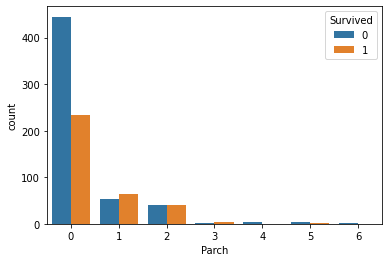

In [25]:
for i in train_data.Parch.unique():
    temp_survived = train_data.loc[train_data.Parch == i]['Survived']
    rate = sum(temp_survived) / len(temp_survived)
    print("% of passengers who have ", i, " of parents/children aboard the Titanic that survived:", rate)
    
sns.countplot(x = 'Parch', data = train_data, hue = 'Survived')
plt.legend(title = 'Survived', loc='upper right')


**Survived ~ # of Sibiling/Spouses (SibSp)**

% of passengers who have  1  of siblings/spouses aboard the Titanic that survived: 0.5358851674641149
% of passengers who have  0  of siblings/spouses aboard the Titanic that survived: 0.34539473684210525
% of passengers who have  3  of siblings/spouses aboard the Titanic that survived: 0.25
% of passengers who have  4  of siblings/spouses aboard the Titanic that survived: 0.16666666666666666
% of passengers who have  2  of siblings/spouses aboard the Titanic that survived: 0.4642857142857143
% of passengers who have  5  of siblings/spouses aboard the Titanic that survived: 0.0
% of passengers who have  8  of siblings/spouses aboard the Titanic that survived: 0.0


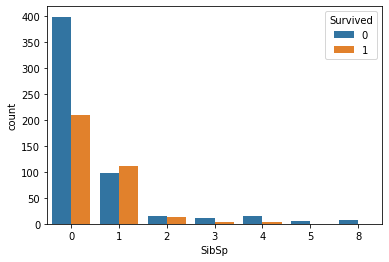

In [26]:
for i in train_data.SibSp.unique():
    temp_survived = train_data.loc[train_data.SibSp == i]['Survived']
    rate = sum(temp_survived) / len(temp_survived)
    print("% of passengers who have ", i, " of siblings/spouses aboard the Titanic that survived:", rate)
    

sns.countplot(x = 'SibSp', data = train_data, hue = 'Survived')
plt.legend(title = 'Survived', loc='upper right')

**Survived ~ Age**

% of Adults that survived: 0.36176066024759285
% of Infants that survived: 0.6666666666666666
% of Teens that survived: 0.4105263157894737
% of Kids that survived: 0.5128205128205128


<AxesSubplot:xlabel='AgeGroup', ylabel='count'>

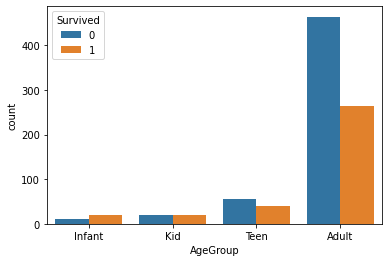

In [27]:
for i in train_data.AgeGroup.unique():
    temp_survived = train_data.loc[train_data.AgeGroup == i]['Survived']
    rate = sum(temp_survived) / len(temp_survived)
    print("% of", i + 's', "that survived:", rate)

sns.countplot(x = 'AgeGroup', data = train_data, hue = 'Survived')

###### The features- PassengerId, Name, Number of Ticket, Cabin, Embarked and Fare, are not affecting in any way the chance to survive or not.

# **Model Building**

### Data Preparation
Before using the classification models, let's prepered our data:

In [28]:
X = train_data.loc[:, ("Sex_cat", "Pclass", "SibSp", "Parch", "Age")]
y = train_data["Survived"].values

The feature matrix, X:

In [29]:
X

,Sex_cat,Pclass,SibSp,Parch,Age
0,1,3,1,0,22.000000
1,0,1,1,0,38.000000
2,0,3,0,0,26.000000
3,0,1,1,0,35.000000
4,1,3,0,0,35.000000
...,...,...,...,...,...
886,1,2,0,0,27.000000
887,0,1,0,0,19.000000
888,0,3,1,2,29.699118
889,1,1,0,0,26.000000


The target column, y:

In [30]:
y[:5]

array([0, 1, 1, 1, 0])

#### Splitting the dataset into the Training set and Test set

In [31]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [32]:
X_train

,Sex_cat,Pclass,SibSp,Parch,Age
140,0,3,0,2,29.699118
439,1,2,0,0,31.000000
817,1,2,1,1,31.000000
378,1,3,0,0,20.000000
491,1,3,0,0,21.000000
...,...,...,...,...,...
835,0,1,1,1,39.000000
192,0,3,1,0,19.000000
629,1,3,0,0,29.699118
559,0,3,1,0,36.000000


#### Feature Scaling

In [33]:
# feature scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## **Feature and Model Selection**

In [34]:
from sklearn.model_selection import cross_val_score, GridSearchCV, RepeatedStratifiedKFold
#cross_val_predict, KFold, 
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFECV

In [35]:
# some experience....
# here we use Decision Tree as estimator in the RFECV
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import RandomForestClassifier
# rfe = RFECV(estimator=LogisticRegression(), cv = 10)
# rfe = rfe.fit(X_train,y_train)
# print("Feature ranking: ", rfe.ranking_)

# # extracting the selected features.  get_support() function helps us to get those features names. 
# mask = rfe.get_support()
# features = X.columns
# best_features = features[mask]
 
# print("All features: ", X.shape[1])
# print(features)

# print("Selected best: ", best_features.shape[0])
# print(features[mask])

Let's run RFECV with different estimators to select features. Additionally, let's run some classification models, to get intuition about which estimator and classification algorithm will give us the best results.

After we chose the estimator and the model, we can check which features are selected and use GridSearchCV to find the best hyperparameters for the chosen model.

In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

In [37]:
# get a list of models to evaluate
def get_models(modelc):
    models = dict()
    # lr
    rfe = RFECV(estimator=LogisticRegression())
    model = modelc
    models['lr'] = Pipeline(steps=[('s',rfe),('m',model)])
    # perceptron
    rfe = RFECV(estimator=Perceptron())
    model = modelc
    models['per'] = Pipeline(steps=[('s',rfe),('m',model)])
    # cart
    rfe = RFECV(estimator=DecisionTreeClassifier())
    model = modelc
    models['cart'] = Pipeline(steps=[('s',rfe),('m',model)])
    # rf
    rfe = RFECV(estimator=RandomForestClassifier())
    model = modelc
    models['rf'] = Pipeline(steps=[('s',rfe),('m',model)])
    # gbm
    rfe = RFECV(estimator=GradientBoostingClassifier())
    model = modelc
    models['gbm'] = Pipeline(steps=[('s',rfe),('m',model)])
    # svm
    rfe = RFECV(estimator=SVC(kernel='linear'))
    model = modelc
    models['svm'] = Pipeline(steps=[('s',rfe),('m',model)])
    return models

# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    return scores

models_dict = {'LR': LogisticRegression(random_state=0),
               'SVM': SVC(kernel='linear', random_state=0),
               'RF': RandomForestClassifier(),
               'KNN': KNeighborsClassifier(),
               'NB': GaussianNB()}

# get the models to evaluate
for i in models_dict.keys():
    print('\n'+i+'\n')
    models = get_models(models_dict[i])
    # evaluate the models and store results
    results, names = list(), list()
    for name, model in models.items():
        scores = evaluate_model(model, X_train, y_train)
        results.append(scores)
        names.append(name)
        print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))


LR

>lr 0.789 (0.045)
>per 0.787 (0.046)
>cart 0.783 (0.041)
>rf 0.787 (0.042)
>gbm 0.784 (0.044)
>svm 0.786 (0.045)

SVM

>lr 0.786 (0.045)
>per 0.786 (0.045)
>cart 0.786 (0.045)
>rf 0.786 (0.045)
>gbm 0.786 (0.045)
>svm 0.786 (0.045)

RF

>lr 0.805 (0.045)
>per 0.792 (0.048)
>cart 0.793 (0.048)
>rf 0.801 (0.051)
>gbm 0.801 (0.050)
>svm 0.786 (0.045)

KNN

>lr 0.798 (0.045)
>per 0.796 (0.046)
>cart 0.789 (0.055)
>rf 0.806 (0.044)
>gbm 0.802 (0.044)
>svm 0.747 (0.077)

NB

>lr 0.781 (0.050)
>per 0.769 (0.052)
>cart 0.764 (0.046)
>rf 0.764 (0.046)
>gbm 0.763 (0.047)
>svm 0.786 (0.045)


O.K, let's continue with the two models with the highest accuracy score-
- Random Forest + Random Forest as estimator in the RFECV (accuracy score = 0.8).
- K-NN + Random Forest as estimator in the RFECV (accuracy score = 0.806).


## **Random Forest**
The feature that were selected:

In [38]:
rf_rfe = RFECV(estimator=RandomForestClassifier())
rf_pipe = Pipeline(steps=[('s',rf_rfe),('m',RandomForestClassifier())])

X_new = rf_rfe.fit_transform(X_train, y_train)
print("Feature ranking: ", rf_rfe.ranking_)

mask = rf_rfe.get_support()
features = X.columns
best_features = features[mask]

# print("All features: ", x.shape[1])
# print(features)

print("Selected best: ", best_features.shape[0])
print(features[mask])

Feature ranking:  [1 1 1 2 1]
Selected best:  4
Index(['Sex_cat', 'Pclass', 'SibSp', 'Age'], dtype='object')


In [39]:
X_train[:,mask]

array([[-1.37207547,  0.81925059, -0.46445234, -0.00282437],
       [ 0.72882288, -0.38096838, -0.46445234,  0.09662937],
       [ 0.72882288, -0.38096838,  0.41270964,  0.09662937],
       ...,
       [ 0.72882288,  0.81925059, -0.46445234, -0.00282437],
       [-1.37207547,  0.81925059,  0.41270964,  0.47888431],
       [ 0.72882288, -0.38096838,  0.41270964,  2.31370804]])

Evaluate the model

In [40]:
# evaluate model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(rf_pipe, X_new, y_train, scoring='accuracy', cv=cv, error_score='raise')
# report performance
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Accuracy: 0.800 (0.049)


Find the best hyperparameters using GridSearchCV

In [41]:
# Criterion
criterion = ['gini', 'entropy']
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'m__criterion': criterion,
               'm__n_estimators': n_estimators,
               'm__max_features': max_features,
               'm__max_depth': max_depth,
               'm__min_samples_split': min_samples_split,
               'm__min_samples_leaf': min_samples_leaf,
               'm__bootstrap': bootstrap}

In [42]:
'''#run very slow
rf_grid_search = GridSearchCV(rf_pipe,
                           param_grid = random_grid,
                           scoring = 'accuracy',
                           cv = cv)
rf_grid_search.fit(X_new, y_train)
best_accuracy = rf_grid_search.best_score_
best_parameters = rf_grid_search.best_params_
print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
print("Best Parameters:", best_parameters)'''

'#run very slow\nrf_grid_search = GridSearchCV(rf_pipe,\n                           param_grid = random_grid,\n                           scoring = \'accuracy\',\n                           cv = cv)\nrf_grid_search.fit(X_new, y_train)\nbest_accuracy = rf_grid_search.best_score_\nbest_parameters = rf_grid_search.best_params_\nprint("Best Accuracy: {:.2f} %".format(best_accuracy*100))\nprint("Best Parameters:", best_parameters)'

In [43]:
rf_clf = RandomForestClassifier(n_estimators=2000, criterion='gini')
rf_clf.fit(X_new, y_train)
y_pred = rf_clf.predict(X_test[:,mask])
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

[[97 13]
 [20 49]]


0.8156424581005587

In [44]:
X_train[:,[0,1,2,4]]

array([[-1.37207547,  0.81925059, -0.46445234, -0.00282437],
       [ 0.72882288, -0.38096838, -0.46445234,  0.09662937],
       [ 0.72882288, -0.38096838,  0.41270964,  0.09662937],
       ...,
       [ 0.72882288,  0.81925059, -0.46445234, -0.00282437],
       [-1.37207547,  0.81925059,  0.41270964,  0.47888431],
       [ 0.72882288, -0.38096838,  0.41270964,  2.31370804]])

In [45]:
X_new

array([[-1.37207547,  0.81925059, -0.46445234, -0.00282437],
       [ 0.72882288, -0.38096838, -0.46445234,  0.09662937],
       [ 0.72882288, -0.38096838,  0.41270964,  0.09662937],
       ...,
       [ 0.72882288,  0.81925059, -0.46445234, -0.00282437],
       [-1.37207547,  0.81925059,  0.41270964,  0.47888431],
       [ 0.72882288, -0.38096838,  0.41270964,  2.31370804]])

Predict the test set

In [46]:
'''
# The next step:
rf_pred = rf_pipe.predict(X_test)
cm = confusion_matrix(y_test, rf_pred)
print(cm)
accuracy_score(y_test, rf_pred)
'''

'\n# The next step:\nrf_pred = rf_pipe.predict(X_test)\ncm = confusion_matrix(y_test, rf_pred)\nprint(cm)\naccuracy_score(y_test, rf_pred)\n'

## **K-NN**

In [47]:
knn_rfe = RFECV(estimator=RandomForestClassifier())
knn_pipe = Pipeline(steps=[('s',knn_rfe),('m',KNeighborsClassifier())])

X_new_knn = knn_rfe.fit_transform(X_train, y_train)
print("Feature ranking: ", rf_rfe.ranking_)

mask = knn_rfe.get_support()
features = X.columns
best_features = features[mask]

# print("All features: ", x.shape[1])
# print(features)

print("Selected best: ", best_features.shape[0])
print(features[mask])

Feature ranking:  [1 1 1 2 1]
Selected best:  5
Index(['Sex_cat', 'Pclass', 'SibSp', 'Parch', 'Age'], dtype='object')


In [48]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(knn_pipe, X_new_knn, y_train, scoring='accuracy', cv=cv, error_score='raise')
# report performance
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Accuracy: 0.799 (0.049)


In [49]:
# Number of neighbors
n_neighbors = [21]
# Weight function used in prediction
weights = ['uniform']
# Algorithm used to compute the nearest neighbors
algorithm = ['auto', 'ball_tree', 'kd_tree', 'brute']
# Euclidean distance
metric = ['minkowski']
p = [2]

# Create the knn hyperparameters grid
knn_grid = {'m__n_neighbors': n_neighbors,
               'm__weights': weights,
               'm__algorithm': algorithm,
               'm__metric': metric,
               'm__p': p}

In [50]:
''' # run very slow
knn_grid_search = GridSearchCV(knn_pipe,
                           param_grid = knn_grid,
                           scoring = 'accuracy',
                           cv = cv)
rf_grid_search.fit(X_new_knn, y_train)
best_accuracy = knn_grid_search.best_score_
best_parameters = knn_grid_search.best_params_
print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
print("Best Parameters:", best_parameters)
'''

' # run very slow\nknn_grid_search = GridSearchCV(knn_pipe,\n                           param_grid = knn_grid,\n                           scoring = \'accuracy\',\n                           cv = cv)\nrf_grid_search.fit(X_new_knn, y_train)\nbest_accuracy = knn_grid_search.best_score_\nbest_parameters = knn_grid_search.best_params_\nprint("Best Accuracy: {:.2f} %".format(best_accuracy*100))\nprint("Best Parameters:", best_parameters)\n'

In [51]:
'''knn_pred = knn_pipe.predict(X_test[mask])
cm = confusion_matrix(y_test, knn_pred)
print(cm)
accuracy_score(y_test, knn_pred)'''

'knn_pred = knn_pipe.predict(X_test[mask])\ncm = confusion_matrix(y_test, knn_pred)\nprint(cm)\naccuracy_score(y_test, knn_pred)'

## **Model Selection**

To find the best model with the best parameters, let's use cross validation and grid search.

In [52]:
models_accuracy_scores = {}
# best_params = {}

## **Logistic Regression**

Training the Logistic Regression model on the Training set

In [53]:
logistic_classifier = LogisticRegression(random_state=0)
logistic_classifier.fit(X_train, y_train)

LogisticRegression(random_state=0)

Making the Confusion Matrix

In [54]:
y_pred = logistic_classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

[[92 18]
 [17 52]]


0.8044692737430168

Feature Selection

In [55]:
from sklearn.tree import DecisionTreeClassifier
# create pipeline
rfe = RFECV(estimator=LogisticRegression())
model = LogisticRegression()
pipeline = Pipeline(steps=[('s',rfe),('m',model)])
# evaluate model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=1)
n_scores = cross_val_score(pipeline, X_train, y_train, scoring='accuracy', cv=cv, error_score='raise')
# report performance
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Accuracy: 0.800 (0.045)


In [56]:
rfe.fit(X_train, y_train)
mask = rfe.get_support()
features = X.columns
best_features = features[mask]
 
print("All features: ", X.shape[1])
print(features)

print("Selected best: ", best_features.shape[0])
print(features[mask])

All features:  5
Index(['Sex_cat', 'Pclass', 'SibSp', 'Parch', 'Age'], dtype='object')
Selected best:  3
Index(['Sex_cat', 'Pclass', 'Age'], dtype='object')


In [57]:
# model.fit(X_new, y_train)
# pip_pred = pipeline.predict(X_test)
# cm = confusion_matrix(y_test, pip_pred)
# print(cm)
# accuracy_score(y_test, pip_pred)

Applying k-Fold Cross Validation

In [58]:
accuracies = cross_val_score(estimator = logistic_classifier, X = X_train, y = y_train, cv = 10)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Accuracy: 78.38 %
Standard Deviation: 4.74 %


Applying Grid Search to find the best model and the best parameters

In [59]:
parameters = [{'C': [0.01, 0.1, 0.15, 0.25, 0.5, 0.75, 1], 'penalty': ['l2'], 'solver': ['newton-cg', 'lbfgs', 'sag', 'saga']},
              {'penalty': ['none'], 'solver': ['newton-cg', 'lbfgs', 'sag', 'saga']},
              {'C': [0.01, 0.1, 0.15,  0.25, 0.5, 0.75, 1], 'penalty': ['l2', 'l1'], 'solver': ['liblinear', 'saga']},
              {'C': [0.01, 0.1, 0.15, 0.25, 0.5, 0.75, 1], 'penalty': ['elasticnet'], 'solver': ['saga'], 'l1_ratio': [0.25, 0.5, 0.75]}]

grid_search = GridSearchCV(estimator = logistic_classifier,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 10)
grid_search.fit(X_train, y_train)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_
print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
print("Best Parameters:", best_parameters)

Best Accuracy: 80.49 %
Best Parameters: {'C': 0.1, 'penalty': 'l1', 'solver': 'saga'}


In [60]:
grid_pred = grid_search.predict(X_test)
accuracy_score(y_test, grid_pred)

0.7877094972067039

In [61]:
grid_search

GridSearchCV(cv=10, estimator=LogisticRegression(random_state=0),
             param_grid=[{'C': [0.01, 0.1, 0.15, 0.25, 0.5, 0.75, 1],
                          'penalty': ['l2'],
                          'solver': ['newton-cg', 'lbfgs', 'sag', 'saga']},
                         {'penalty': ['none'],
                          'solver': ['newton-cg', 'lbfgs', 'sag', 'saga']},
                         {'C': [0.01, 0.1, 0.15, 0.25, 0.5, 0.75, 1],
                          'penalty': ['l2', 'l1'],
                          'solver': ['liblinear', 'saga']},
                         {'C': [0.01, 0.1, 0.15, 0.25, 0.5, 0.75, 1],
                          'l1_ratio': [0.25, 0.5, 0.75],
                          'penalty': ['elasticnet'], 'solver': ['saga']}],
             scoring='accuracy')

In [62]:
# models_accuracy_scores["Logistic Regression"] = [logistic_score, logistic_std]

## **K-NN**

In [63]:
'''# search for an optimal value of k for K-NN
from sklearn.neighbors import KNeighborsClassifier
k_range = range(1,31)
k_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k, metric='minkowski', p=2)
    scores = cross_val_score(knn, X_new_knn, y_train, cv = cv, scoring = 'accuracy')
    k_scores.append(scores.mean())
print(k_scores)'''

"# search for an optimal value of k for K-NN\nfrom sklearn.neighbors import KNeighborsClassifier\nk_range = range(1,31)\nk_scores = []\nfor k in k_range:\n    knn = KNeighborsClassifier(n_neighbors=k, metric='minkowski', p=2)\n    scores = cross_val_score(knn, X_new_knn, y_train, cv = cv, scoring = 'accuracy')\n    k_scores.append(scores.mean())\nprint(k_scores)"

In [64]:
'''# plot the value of k for K-NN (x axis) versus the cross-validated accuracy (y axis)
plt.plot(k_range, k_scores)
plt.xlabel('Value of k')
plt.ylabel('Cross-Validated Accuracy')'''

"# plot the value of k for K-NN (x axis) versus the cross-validated accuracy (y axis)\nplt.plot(k_range, k_scores)\nplt.xlabel('Value of k')\nplt.ylabel('Cross-Validated Accuracy')"

In [65]:
'''k_scores.index(max(k_scores))'''

'k_scores.index(max(k_scores))'

The optimal value of k is 27 with 0.786729 accuracy score

In [66]:
'''knn_classifier = KNeighborsClassifier(n_neighbors=26, metric='minkowski', p=2)
knn_accuracies = cross_val_score(knn_classifier, X, y, cv = 10, scoring = 'accuracy')
knn_score = knn_accuracies.mean()
knn_std = knn_accuracies.std()
print(knn_score)
models_accuracy_scores["K-NN"] = [knn_score, knn_std]'''

'knn_classifier = KNeighborsClassifier(n_neighbors=26, metric=\'minkowski\', p=2)\nknn_accuracies = cross_val_score(knn_classifier, X, y, cv = 10, scoring = \'accuracy\')\nknn_score = knn_accuracies.mean()\nknn_std = knn_accuracies.std()\nprint(knn_score)\nmodels_accuracy_scores["K-NN"] = [knn_score, knn_std]'

## **SVM**

In [67]:
from sklearn.svm import SVC
svm_classifier = SVC(kernel='linear', random_state=0)
svm_accuracies = cross_val_score(svm_classifier, X, y, cv = 10, scoring = 'accuracy')
svm_score = svm_accuracies.mean()
svm_std = svm_accuracies.std()
models_accuracy_scores["SVM"] = [svm_score, svm_std]

In [68]:
models_accuracy_scores

{'SVM': [0.786729088639201, 0.028599350013463757]}

## **Naive Bayes**

In [69]:
from sklearn.naive_bayes import GaussianNB
nb_classifier = GaussianNB()
nb_accuracies = cross_val_score(nb_classifier, X, y, cv = 10, scoring = 'accuracy')
nb_score = nb_accuracies.mean()
nb_std = nb_accuracies.std()
models_accuracy_scores["Naive Bayes"] = [nb_score, nb_std]

In [70]:
nb_score

0.762059925093633

## **Random Forest**

In [71]:
from sklearn.ensemble import RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=10, criterion='entropy', random_state=0)
rf_accuracies = cross_val_score(rf_classifier, X, y, cv = 10, scoring = 'accuracy')
rf_score = rf_accuracies.mean()
rf_std = rf_accuracies.std()
models_accuracy_scores["Random forest"] = [rf_score, rf_std]
rf_score

0.7991885143570536

In [72]:
models_accuracy_scores

{'SVM': [0.786729088639201, 0.028599350013463757],
 'Naive Bayes': [0.762059925093633, 0.028809289673386286],
 'Random forest': [0.7991885143570536, 0.039088368060222374]}

In [73]:
# from sklearn.ensemble import RandomForestClassifier

# y = train_data["Survived"]

# features = ["Pclass", "Sex", "SibSp", "Parch"]
# X = pd.get_dummies(train_data[features])
# X_test = pd.get_dummies(test_data[features])

# model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
# model.fit(X, y)
# predictions = model.predict(X_test)

# output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
# output.to_csv('submission.csv', index=False)
# print("Your submission was successfully saved!")

In [74]:
# output.head()